<b>Run in Google Colab

In [ ]:
!pip install swig --quiet
!pip install "gymnasium[box2d]" --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
from collections import namedtuple, deque
from itertools import count
import math
import random
import os
import pickle
from tqdm import tqdm

import gymnasium as gym
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


os.makedirs('lunar_lander_results', exist_ok=True)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

def select_action(state):
    global steps_done
#     случайное значение для определения какой шаг будем делать жадный или случайный
    sample = random.random()

#     установка порога принятия решения - уровня epsilon
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)

    steps_done += 1

    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) вернет наибольшее значение столбца в каждой строке.
            # Второй столбец в результате max - это индекс того места,
            # где был найден максимальный элемент,
            # поэтому мы выбираем действие с наибольшим ожидаемым вознаграждением.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        # Иначы выбираем случайное дайствие
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

def optimize_model(batch_size: int):
    if len(memory) < batch_size:
        return

    transitions = memory.sample(batch_size)

    batch = Transition(*zip(*transitions))

    # Вычислить маску нефинальных состояний и соединить элементы батча
    # (финальным состоянием должно быть то, после которого моделирование закончилось)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                        batch.next_state)), device=device, dtype=torch.bool)

    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])

    # Собираем батчи для состояний, действий и наград
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Вычислить Q(s_t, a) - модель вычисляет Q(s_t),
    # затем мы выбираем столбцы предпринятых действий.
    # Это те действия, которые были бы предприняты для каждого состояния партии в соответствии с policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Вычислить V(s_{t+1}) для всех следующих состояний.
    # Ожидаемые значения действий для не_финальных_следующих_состояний вычисляются
    # на основе "старшей" целевой_сети; выбирается их наилучшее вознаграждение с помощью max(1)[0].
    # Это объединяется по маске, так что мы будем иметь либо ожидаемое значение состояния,
    # либо 0, если состояние было финальным.
    next_state_values = torch.zeros(batch_size, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Вычисляем ожидаемые Q значения
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Объединяем все в общий лосс
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Готовим градиент
    optimizer.zero_grad()
    loss.backward()
    # Обрезаем значения градиента - проблемма исчезающего/взрывающего градиента
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)

    optimizer.step()

In [ ]:
#########################################################
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4
FULL_MEMORY_LENGTH = 10000
#########################################################

n_actions = env.action_space.n
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)

target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

memory = ReplayMemory(FULL_MEMORY_LENGTH)

steps_done = 0

episode_durations = []

num_episodes = 500
total_reward = []

for i_episode in tqdm(range(num_episodes)):
    episode_reward = 0
    # Для каждого эпизода инициализируем начальное состояние
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    # выполняем действия пока не получим флаг done
    # t - считает сколько шагов успели сделать пока шест не упал
    for t in count():
        # выбираем действие [0, 1]
        action = select_action(state)
        # Делаем шаг
        observation, reward, terminated, truncated, _ = env.step(action.item())
        episode_reward += reward

        # Преобразуем в тензор
        reward = torch.tensor([reward], device=device)

        # Объединяем done по двум конечным состояниям
        done = terminated or truncated

        # присваиваем следующее состояние
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # отправляем в память
        memory.push(state, action, next_state, reward)

        # переходим на следующее состояние
        state = next_state

        # запускаем обучение сети
        optimize_model(batch_size=128)

        # делаем "мягкое" обновление весов
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()

        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        # Если получили terminated or truncated завершаем эпизод обучения
        if done:
            # добавляем в массив продолжительность эпизода
            episode_durations.append(t + 1)
            total_reward.append(episode_reward)
            break
    if len(total_reward) > 100 and abs(np.mean(total_reward[-5:]) - 500) < 20:
        break

print('Complete')

100%|██████████| 500/500 [16:58<00:00,  2.04s/it]

Complete


In [ ]:
# Вычисляем среднюю награду за последние 100 эпизодов
avg_rewards = list()
for i in range(100, len(total_reward)):
    avg_reward = np.mean(total_reward[i-100:i])
    avg_rewards.append(avg_reward)

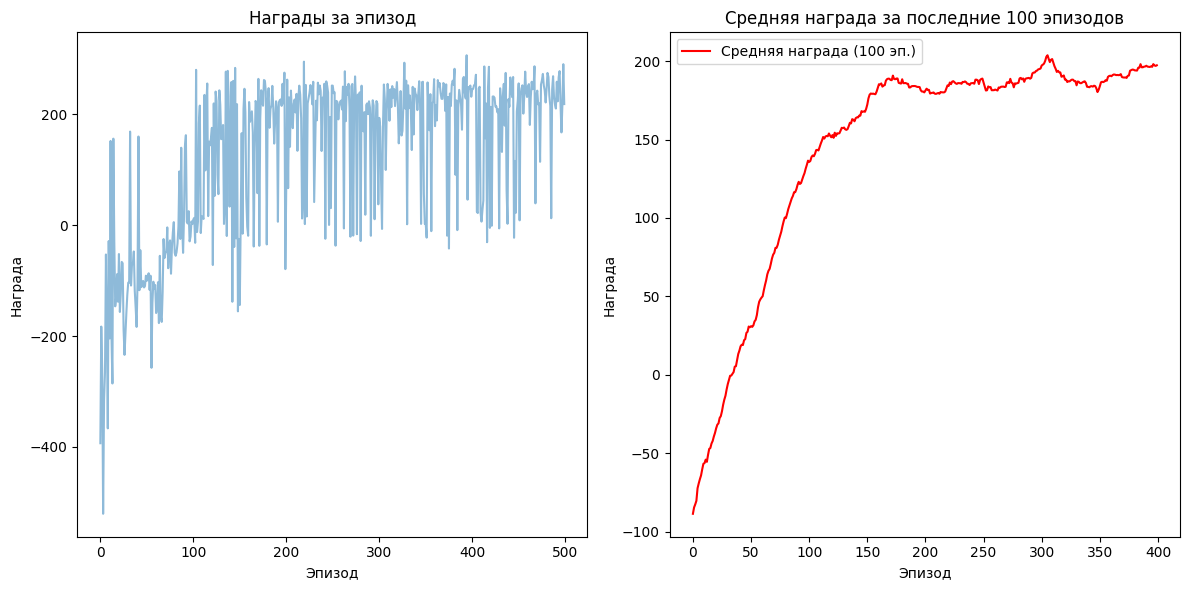

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(total_reward, alpha=0.5, label='Награда за эпизод')
plt.xlabel('Эпизод')
plt.ylabel('Награда')
plt.title('Награды за эпизод')

plt.subplot(1, 2, 2)
plt.plot(avg_rewards, color='red', label='Средняя награда (100 эп.)')
plt.xlabel('Эпизод')
plt.ylabel('Награда')
plt.title('Средняя награда за последние 100 эпизодов')
plt.legend()

plt.tight_layout()
plt.savefig('lunar_lander_results/rewards_plot.png')
plt.show()

In [ ]:
def select_action_trained(state):
    with torch.no_grad():
        state = torch.tensor([[state]], device=device, dtype=torch.float32)
        # return target_net(state).max(1)[1].view(1, 1)
        return target_net(state).argmax().item()


def run_episode(env):
    frames = []
    state, _ = env.reset()
    done = False

    while not done:
        frames.append(env.render())
        action = select_action_trained(state)
        state, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

    frames.append(env.render())
    return frames


def save_frames_as_gif(frames, path='./lunar_lander_animation.gif'):
    plt.figure(figsize=(frames[0].shape[1]/72.0, frames[0].shape[0]/72.0), dpi=72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)
    anim.save(path, writer='pillow', fps=10)

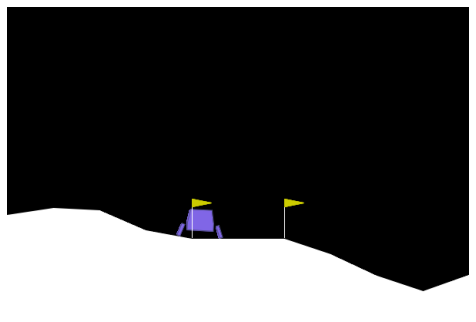

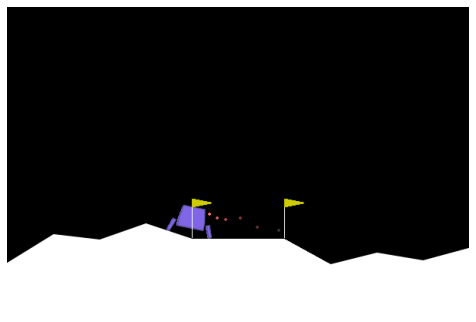

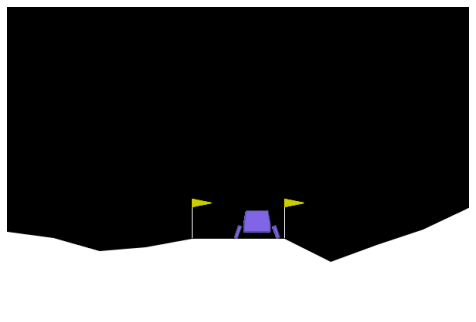

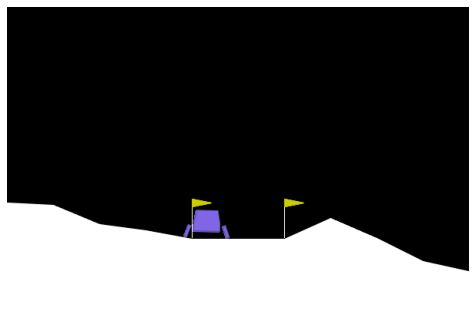

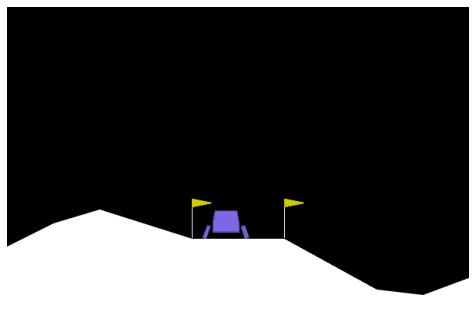

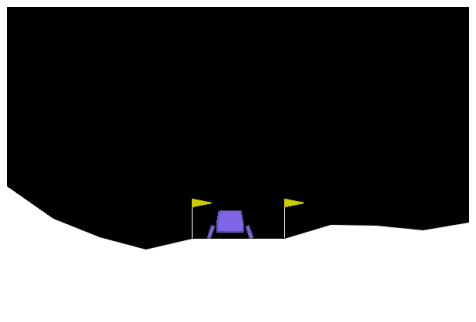

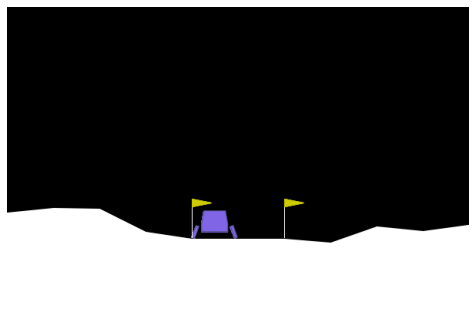

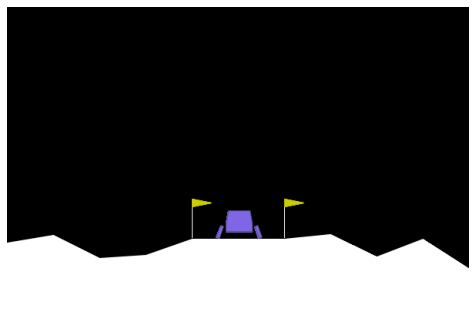

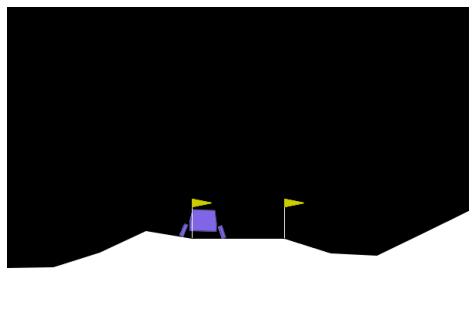

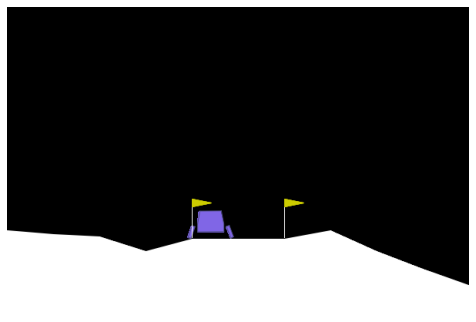

In [ ]:
for i in range(10):
    env = gym.make('LunarLander-v3', render_mode="rgb_array")
    frames = run_episode(env)
    save_frames_as_gif(frames, path=f'./lunar_lander_animation-{i}.gif')